# Further Analysis for STAT3888 Group Project

### Importing Packages, Loading Data

In [56]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')


biom_data = pd.read_csv("data/tech_biom.csv")
nutr_data = pd.read_csv("data/AHS11nutrient.csv")

### Selecting Response Variables and Confounders

In [58]:
# Select relevant cardiovascular variables 
response_vars = ["ABSPID", "BMISC", "HCHOLBC", "CHOLRESB", "CHOLNTR", "HDLCHREB", "LDLNTR",
                "LDLRESB", "DIASTOL", "SYSTOL", "HSUGBC"]
confounders = ["ADTOTSE", "SMKSTAT", "AGEC", "EXLWTBC", "SF2SA1QN", "SEX", "DIAHBRSK"]


cardio_data = biom_data[response_vars + confounders]


# Or as another option, selecting all the data variables
# cardio_data = biom_data[biom_data.columns[~biom_data.columns.str.endswith('MISS')]]

### Cleaning and Combining Data

In [53]:
#Remove second day measurements from nutrition data - varaibles ending in '2'
#Remove percentage measurements from nutrition data - varaibles containing 'PE'
condensed_nutr_data = nutr_data[nutr_data.columns[~nutr_data.columns.str.endswith('2') & ~nutr_data.columns.str.contains('PE')]]

#Drop all rows with missing values in cardiovascular data and combine to make final dataset
cleaned_cardio_data = cardio_data.dropna()
combined_data = pd.merge(cleaned_cardio_data, condensed_nutr_data, on = "ABSPID")

### Setting up Prediction Variables (X)

In [54]:
non_predictors = ["ABSHID"]
X = combined_data.drop(response_vars + non_predictors, axis = 1)

### Function for Lasso Regression

In [43]:
def lasso_reg(response):
    y = combined_data[response]
    reg = LassoCV()
    reg.fit(X, y)
    print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
    print("Best score using built-in LassoCV (R-Squared): %f" % reg.score(X,y))
    coef = pd.Series(reg.coef_, index = X.columns)
    
    # Subset to only non-zero coefficients and plot.
    coef = coef[coef != 0]
    imp_coef = coef.sort_values()
    plt.rcParams['figure.figsize'] = (8.0, 10.0)
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using Lasso Model for " + response)
    plt.ylabel('Predictor Variable')
    plt.xlabel('Coefficient Estimate')

### Function for Random Forest

In [44]:
def random_forest(response):
    y = combined_data[response]
    
    # KFOLD CV TO GET MODEL ACCURACY
    cv = KFold(n_splits=10, random_state=1, shuffle=True)
    # create model
    model = RandomForestClassifier()
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))


    #SIMPLE TRAIN TEST SPLIT FOR FEATURE IMPORTANCE
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
    forest = RandomForestClassifier(random_state=0)
    forest.fit(X_train, y_train)
    result = permutation_importance(forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
    forest_importances = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending = False)
    
    plt.rcParams['figure.figsize'] = (8, 8)
    fig, ax = plt.subplots()
    forest_importances[0:10].plot.bar(ax=ax)   # SHOW ONLY FIRST 10
    ax.set_title("Feature importances using permutation on full model for " + response)
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    plt.show()
    
    # Explanation for permutation importance
    # https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance

### SYSTOL

Best alpha using built-in LassoCV: 6.114312
Best score using built-in LassoCV (R-Squared): 0.253246


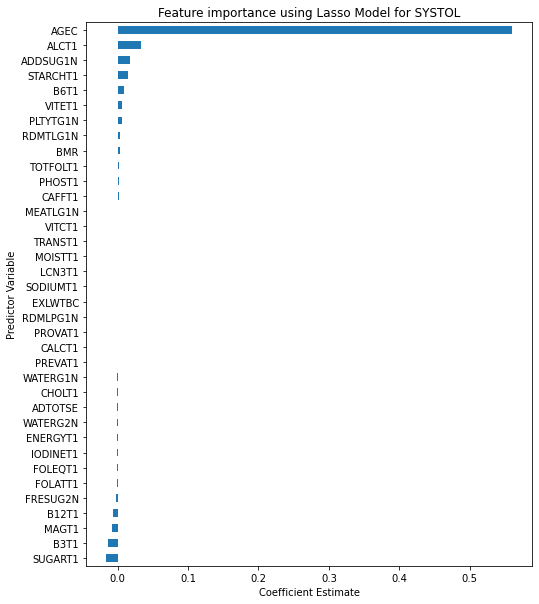

In [59]:
lasso_reg("SYSTOL")

### DIASTOL

Best alpha using built-in LassoCV: 11.851595
Best score using built-in LassoCV (R-Squared): 0.214203


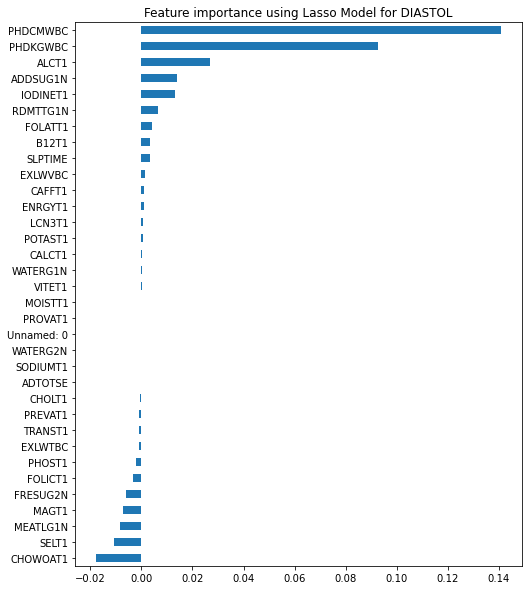

In [32]:
lasso_reg("DIASTOL")

### BMISC

Best alpha using built-in LassoCV: 1.872056
Best score using built-in LassoCV (R-Squared): 0.989908


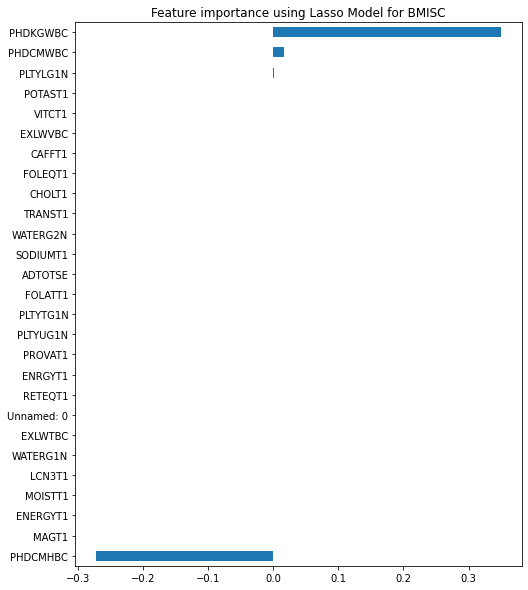

In [33]:
lasso_reg("BMISC")

### CHOLRESB

Accuracy: 0.251 (0.089)


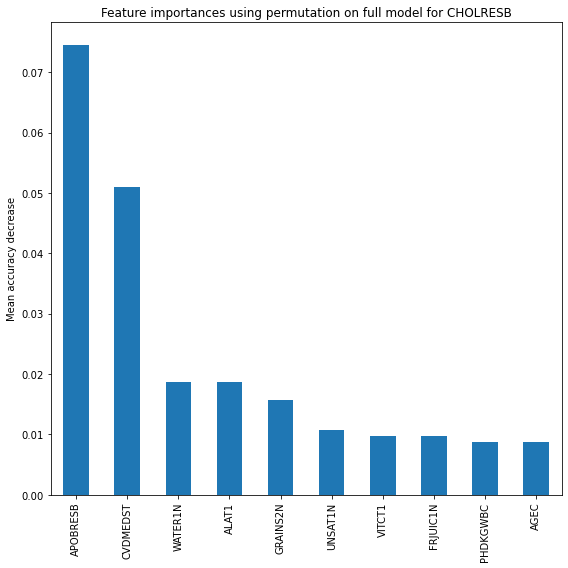

In [34]:
random_forest("CHOLRESB")